In [1]:
%matplotlib inline
%precision 16
import numpy
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt
from scipy.integrate import quad

Recall from modified backward euler method, the implicit finite different scheme is:
$$
    a_{i,j} U^{n+1}_{i-1,j-1}+ b_{i,j} U^{n+1}_{i-1,j} + c_{i,j} U^{n+1}_{i-1, j+1} + d_{i,j} U^{n+1}_{i, j-1} + e_{i,j} U^{n+1}_{i, j} + f_{i,j} U^{n+1}_{i, j+1} + g_{i,j} U^{n+1}_{i+1, j-1} + h_{i,j} U^{n+1}_{i+1, j} + k_{i,j} U^{n+1}_{i+1, j+1} = U^{n}_{i,j}
$$

### Boundary condition

#### Left BC: $v = 0$ [Implement in the right hand side]

After discretizing the boundary condition, we get:
$$
\begin{align}
    \left( 1 - rS_i\frac{\Delta t}{\Delta S} + \kappa\theta\frac{\Delta t}{\Delta v} + r\Delta t\right)U^{n+1}_{i,0} &= U^{n}_{i,0} - rS_i\frac{\Delta t}{\Delta s} U^{n+1}_{i-1,0} + \kappa\theta\frac{\Delta t}{\Delta v}U^{n+1}_{i,1}\\
    &=U^{n}_{i,0} - \frac{rS_i\Delta t}{\Delta s} U^{n+1}_{i-1,0} + \frac{\kappa\theta\Delta t}{\Delta v} U^{n+1}_{i,1}\\
\end{align}
$$ 
$$
ri\Delta t U^{n+1}_{i-1,0} + \left( 1 - rS_i\frac{\Delta t}{\Delta S} + \kappa\theta\frac{\Delta t}{\Delta v} + r\Delta t\right)U^{n+1}_{i,0} - \frac{\kappa\theta\Delta t}{\Delta v} U^{n+1}_{i,1}=U^{n}_{i,0}
$$ for $i=1,...,N-2$, For i=0, we use the boundary condition for $S=0$, $U_{0,0}=0$. Since we can't get $U^{n+1}_{i,1}$ at this moment, we change to use the first order forward discretization which is fully explicit:
$$
ri\Delta t U^{n+1}_{i-1,0} + \left( 1 - rS_i\frac{\Delta t}{\Delta S} + \kappa\theta\frac{\Delta t}{\Delta v} + r\Delta t\right)U^{n+1}_{i,0}=U^{n}_{i,0} + \frac{\kappa\theta\Delta t}{\Delta v} U^{n}_{i,1}
$$
Further, since we know the value of $U^{n+1}_{0,0}$, we can simply calculate $U^{n+1}_{i,0}$, $i=1, \dots $ by
$$
U^{n+1}_{i,0}= \frac{U^{n}_{i,0} + \frac{\kappa\theta\Delta t}{\Delta v} U^{n}_{i,1} - ri\Delta t U^{n+1}_{i-1,0}}{\left( 1 - rS_i\frac{\Delta t}{\Delta S} + \kappa\theta\frac{\Delta t}{\Delta v} + r\Delta t\right)}
$$
#### Right BC: $v \to \infty$ [Implement in the right hand side]
$$U_{i,M-1} = S_i,~for~i=0,\dots,N-1$$
#### Lower BC: $S = 0$ [Ignore]
$$U_{0,j} = 0,~for~j=0,\dots,M-1$$
#### Upper BC: $S \to \infty$ [Implement both in the matrix and the right hand side]
For $j=1,\dots, M-2$
$$
\begin{align}
  U^{n+1}_{N-1,j} &= \frac{2\Delta s + 4U^{n+1}_{N-2,j} - U^{n+1}_{N-3,j}}{3}\\
                  &= \frac 4 3U^{n+1}_{N-2,j} - \frac 1 3 U^{n+1}_{N-3,j} + \frac{2\Delta s}{3}
\end{align}
$$

In [2]:
# Set coefficient
rho   = 0.8
sigma = 0.3
r     = 0.03
kappa = 2.0
theta = 0.2

K = 100.0

# Set domain: [0,S] x [0,V] x [0,T]
S = 200.0
V = 1.0
T = 1.0

# Discretize domain
M = 40
N = 40
L = 100

s = numpy.linspace(0.0, S*1.2, N+2)
v = numpy.linspace(0.0, V*1.3, M+2)
t = numpy.linspace(0.0, T, L)

s = s[1:-1]
v = v[1:-1]

delta_s = s[1] - s[0]
delta_v = v[1] - v[0]
delta_t = t[1] - t[0]

A = numpy.zeros([M*N, M*N])
rhs = numpy.zeros(M*N)

In [3]:
# Construct matrix A
for irow in range(M*N):
    i = irow/M + 1
    j = numpy.mod(irow, M) + 1
    
    temp = rho*sigma*i*j*delta_t/4.0
    a = -temp
    k = -temp
    c = temp
    g = temp
    b = -0.5 * delta_t * (i**2 * v[j-1] - r*i)
    d = -0.5 * delta_t/delta_v * (sigma**2 * j - kappa*(theta - v[j-1]))
    e = 1 + delta_t * (r + i**2 * v[j-1] + sigma**2 * j/delta_v)
    f = -0.5 * delta_t/delta_v * (sigma**2 * j + kappa*(theta - v[j-1]))
    h = -0.5 * delta_t * (i**2 * v[j-1] + r*i)
    
    i = i-1
    j = j-1
    
    if( i == 0 ):
        if( j==0 ):
            A[irow, irow]         = e
            A[irow, irow + 1]     = f
            A[irow, irow + M]     = h
            A[irow, irow + M + 1] = k
        elif( j==M-1 ):
            A[irow, irow - 1]     = d
            A[irow, irow]         = e
            A[irow, irow + M - 1] = g
            A[irow, irow + M]     = h
            rhs[irow]             = -k * s[i+1] 
        else:
            A[irow, irow - 1]     = d
            A[irow, irow]         = e
            A[irow, irow + 1]     = f
            A[irow, irow + M - 1] = g
            A[irow, irow + M]     = h
            A[irow, irow + M + 1] = k
    elif (i == N-1):
        if( j==0 ):
            A[irow, irow - M ]    = b - h*1.0/3.0
            A[irow, irow - M + 1] = c - k*1.0/3.0
            A[irow, irow]         = e + h*4.0/3.0 
            A[irow, irow + 1]     = f + k*4.0/3.0
            rhs[irow]             = -2.0/3.0*delta_s*(h+k)
        elif( j==M-1 ):
            A[irow, irow - M - 1] = a - g*1.0/3.0
            A[irow, irow - M ]    = b - h*1.0/3.0
            A[irow, irow - 1]     = d + g*4.0/3.0
            A[irow, irow]         = e + h*4.0/3.0 
            rhs[irow]             = -(c*s[i-1] + f *s[i] + k*S)- 2.0/3.0*delta_s*(g+h)
        else:
            A[irow, irow - M - 1] = a - g*1.0/3.0
            A[irow, irow - M ]    = b - h*1.0/3.0
            A[irow, irow - M + 1] = c - k*1.0/3.0
            A[irow, irow - 1]     = d + g*4.0/3.0
            A[irow, irow]         = e + h*4.0/3.0 
            A[irow, irow + 1]     = f + k*4.0/3.0
            rhs[irow]             = -2.0/3.0*delta_s*(h+k+g)
    else:
        if( j==0 ):
            A[irow, irow - M ]    = b
            A[irow, irow - M + 1] = c
            A[irow, irow]         = e
            A[irow, irow + 1]     = f
            A[irow, irow + M]     = h
            A[irow, irow + M + 1] = k
        elif( j==M-1 ):
            rhs[irow]             = -( s[i-1] * c + s[i] * f + s[i+1] * k )
            A[irow, irow - M - 1] = a  
            A[irow, irow - M ]    = b
            A[irow, irow - 1]     = d
            A[irow, irow]         = e
            A[irow, irow + M - 1] = g
            A[irow, irow + M]     = h            
        else:
            A[irow, irow - M - 1] = a  
            A[irow, irow - M ]    = b
            A[irow, irow - M + 1] = c
            A[irow, irow - 1]     = d
            A[irow, irow]         = e
            A[irow, irow + 1]     = f
            A[irow, irow + M - 1] = g
            A[irow, irow + M]     = h
            A[irow, irow + M + 1] = k

In [4]:
U_old = numpy.zeros(M*N)
U_new = numpy.zeros(M*N)

U_bc  = numpy.zeros(N+2)
# Initialize U vector
U_bc[0]  = 0
U_bc[-1] = numpy.maximum(S - K, 0.0)
for i in range(N):
    U_old[i*M: (i+1)*M] = numpy.maximum(numpy.ones(M) * s[i] - K , 0.0)
    U_bc[i] = numpy.maximum(s[i] - K, 0.0)

In [5]:
temp = numpy.empty(N+2)
temp[0] = 0.0
for timestep in t:
    for i in xrange(N+2):
        if i == 0:
            continue       
        else:
            if i == N+1:
                temp1 = (2.0*delta_s + 4.0 * U_old[(i-2)*M + 1]- U_old[(i-3)*M+1] )/3.0
            else:
                temp1 = U_old[(i-1)*M + 1]
            temp[i] = ( U_bc[i] - r*i*delta_t*temp[i-1] + kappa*theta*delta_t*temp1 / delta_v )\
                      /( 1 - r*i*delta_t + kappa*theta*delta_t/delta_v + r*delta_t )
    # a, d, g
    for i in xrange(N):
        temp2 = rho*sigma*i*delta_t/4.0
        a = -temp2
        d = -0.5 * delta_t/delta_v * (sigma**2- kappa*(theta - v[1]))
        g = temp2
        rhs[i*M] = -a*temp[i] -d*temp[i+1] -g*temp[i+2]
    U_new = numpy.linalg.solve(A, U_old+rhs)
    U_old = numpy.copy(U_new)

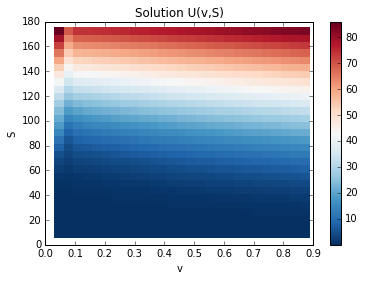

In [6]:
U_sol = numpy.reshape(U_new, [N, M])
E, X = numpy.meshgrid(v[:-12], s[:-10])

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
sol_plot = axes.pcolor(E, X, U_sol[:-10,:-12], cmap=plt.get_cmap('RdBu_r'))
axes.set_title("Solution U(v,S)")
axes.set_xlabel("v")
axes.set_ylabel("S")
cbar = fig.colorbar(sol_plot, ax=axes)